In [23]:
import numpy as np
from scipy.optimize import minimize

def fitr2(X, Pold, Pnew, NS, model):
    # Determine parameters based on the model and input dimensions
    if model == 1 and X.shape[0] == 6:
        go, ro, bo, gn, rn, bn = X
    elif model == 1 and X.shape[0] == 4:
        go, ro, bo, gn = X[0], X[1], X[3], X[0]
        rn, bn = X[2], X[3]
    elif model == 2 and X.shape[0] == 3:
        g, ro, rn = X
    elif model == 3 and X.shape[0] == 2:
        bo, bn = X
    else:
        raise ValueError("Invalid model or input dimension for X")

    naOld = NS * Pold
    nbOld = NS * (1 - Pold)
    naNew = NS * Pnew
    nbNew = NS * (1 - Pnew)

    t = np.arange(11)

    if model == 1:  # exemplar
        prOld = 1 / (1 + bo * np.exp(-ro * (go ** t)))
        prNew = 1 / (1 + bn * np.exp(-rn * (gn ** t)))
    elif model == 2:  # power
        prOld = ro * (1 + t) ** g
        prNew = rn * (1 + t) ** g
    else:  # baseline
        prOld = bo * np.ones(11)
        prNew = bn * np.ones(11)

    pr = np.column_stack((prOld, prNew))

    GROld = np.dot(naOld, np.log(prOld)) + np.dot(nbOld, np.log(1 - prOld))
    GRNew = np.dot(naNew, np.log(prNew)) + np.dot(nbNew, np.log(1 - prNew))
    GR = GROld + GRNew

    GCOld = np.dot(naOld, np.log(Pold)) + np.dot(nbOld, np.log(1 - Pold))
    GCNew = np.dot(naNew, np.log(Pnew)) + np.dot(nbNew, np.log(1 - Pnew))
    GC = GCOld + GCNew

    G = 2 * (GC - GR)  # G-squared difference

    return G, pr


Initial results for subject 1: 4.916284217459008
Final results for subject 1: 1.312292042040383
Initial results for subject 2: 8.130710146022011
Final results for subject 2: 1.142282205041795
Initial results for subject 3: 6.142575762397939
Final results for subject 3: 1.0291781442468277
Initial results for subject 4: 5.208451572427521
Final results for subject 4: 0.5394847810426313
Initial results for subject 5: 6.117120311128531
Final results for subject 5: 0.6024822561441852
G-squared difference for each subject, last row is the mean:
[1.31229204 1.14228221 1.02917814 0.53948478 0.60248226 0.92514389]
Mean parameters:
[0.70172817 2.98064924 2.10812032 0.92939992]
Mean observed Old, Mean observed New:
[[0.949 0.906]
 [0.895 0.818]
 [0.833 0.746]
 [0.75  0.692]
 [0.689 0.648]
 [0.633 0.595]
 [0.618 0.569]
 [0.568 0.558]
 [0.584 0.57 ]
 [0.534 0.533]
 [0.533 0.548]]
Mean predicted Old, Mean predicted New:
[[0.95333087 0.89776308]
 [0.89579985 0.82480789]
 [0.82260635 0.75209258]
 [0.74

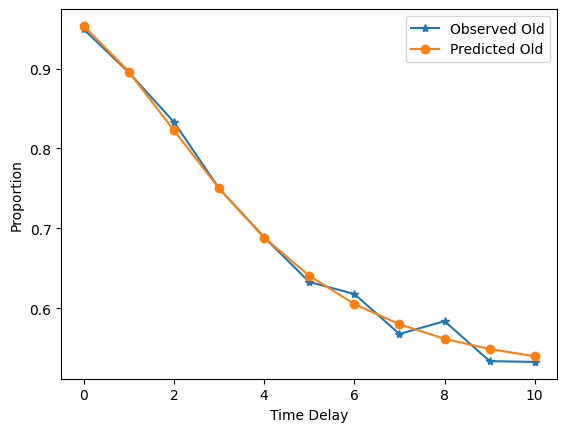

In [24]:
# Load data (replace with actual data loading code)
SPOld = np.load("NormalOldData.npy")  # Replace with correct file paths
SPNew = np.load("NormalNewData.npy")

ns = SPOld.shape[1]  # number of subjects
nd = SPOld.shape[0]  # number of delays

model = 1  # exemplar model

if model == 1:
    X0 = np.array([0.8, 2.0, 1.0, 1.0])  # initial guess for exemplar model
    #X0 = np.array([0.8, 2.0, 1.0, 0.8, 1.0, 1.0])
elif model == 2:
    X0 = np.array([-0.2, 0.9, 0.8])  # initial guess for power model
else:
    X0 = np.array([0.6, 0.6])  # initial guess for baseline model

ChiM = np.zeros(ns)
Parms = np.zeros((len(X0), ns))
PredMold = np.zeros((nd, ns))
PredMnew = np.zeros((nd, ns))

for sub in range(ns):
    Pold = SPOld[:, sub]
    Pnew = SPNew[:, sub]

    # Initial results
    G, pr = fitr2(X0, Pold, Pnew, nd, model)
    print(f"Initial results for subject {sub + 1}: {G}")

    # Optimization
    result = minimize(lambda X: fitr2(X, Pold, Pnew, nd, model)[0], X0, method='Nelder-Mead')
    X_opt = result.x
    G_opt = result.fun

    # Final results
    print(f"Final results for subject {sub + 1}: {G_opt}")

    ChiM[sub] = G_opt
    Parms[:, sub] = X_opt
    G, pr = fitr2(X_opt, Pold, Pnew, nd, model)
    PredMold[:, sub] = pr[:, 0]
    PredMnew[:, sub] = pr[:, 1]

print("G-squared difference for each subject, last row is the mean:")
print(np.append(ChiM, np.mean(ChiM)))

print("Mean parameters:")
print(np.mean(Parms, axis=1))

print("Mean observed Old, Mean observed New:")
print(np.column_stack((np.mean(SPOld, axis=1), np.mean(SPNew, axis=1))))

print("Mean predicted Old, Mean predicted New:")
print(np.column_stack((np.mean(PredMold, axis=1), np.mean(PredMnew, axis=1))))

# Plot the results
import matplotlib.pyplot as plt

t = np.arange(11)
plt.plot(t, np.mean(SPOld, axis=1), '*-', label='Observed Old')
plt.plot(t, np.mean(PredMold, axis=1), 'o-', label='Predicted Old')
plt.xlabel('Time Delay')
plt.ylabel('Proportion')
plt.legend()
plt.show()


In [60]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import chi2
import pennylane as qml
import pandas as pd

# Number of qubits
N = 4

# Use a device that supports noise channels.
dev = qml.device("default.mixed", wires=N)

# Quantum model with three free parameters
def quantum_model(params, time, num_free_params):
    beta, gamma, decay_rate, lambda_factor = params
    J_i = SPOld.mean(axis=1)[:N]
    J_ij = np.outer(SPNew.mean(axis=1)[:N], SPNew.mean(axis=1)[:N])
    J_ij_flat = [J_ij[i, j] for i in range(N) for j in range(i + 1, N)]

    coeffs = gamma * np.array(list(J_i) + J_ij_flat)
    ops = [qml.PauliZ(i) for i in range(N)] + [
        qml.PauliZ(i) @ qml.PauliZ(j) for i in range(N) for j in range(i + 1, N)
    ]
    #H_total = qml.Hamiltonian(coeffs, ops) + qml.Hamiltonian([-1.0] * N, [qml.PauliX(i) for i in range(N)])
    H_total = lambda_factor * (qml.Hamiltonian(coeffs, ops) + qml.Hamiltonian([-1.0] * N, [qml.PauliX(i) for i in range(N)]))

    @qml.qnode(dev)
    def circuit(t):
        for i in range(N):
            qml.PauliX(wires=i)
        scaled_t = beta * t  # Slow down time evolution
        qml.templates.ApproxTimeEvolution(H_total, scaled_t, 100)

        
        p = lambda_factor * (1 - np.exp(-decay_rate * t))
        p = np.clip(p, 0, 1)
        
        for i in range(N):
            qml.AmplitudeDamping(p, wires=i)
        
        return [qml.expval(qml.PauliZ(i)) for i in range(N)]
    
    results = np.array([circuit(t) for t in time])
    excited_probs = (1 - results) / 2.0
    avg_excited_prob = excited_probs.mean(axis=1)
    
    return avg_excited_prob


In [61]:
# Modified fitr2 to use the quantum model
def fitr2_quantum(params, Pold, Pnew, NS, num_free_params):
    time = np.arange(11)
    
    prOld = quantum_model(params, time, num_free_params)
    prNew = quantum_model(params, time, num_free_params)
    
    naOld = NS * Pold
    nbOld = NS * (1 - Pold)
    naNew = NS * Pnew
    nbNew = NS * (1 - Pnew)
    
    GROld = np.dot(naOld, np.log(prOld)) + np.dot(nbOld, np.log(1 - prOld))
    GRNew = np.dot(naNew, np.log(prNew)) + np.dot(nbNew, np.log(1 - prNew))
    GR = GROld + GRNew

    GCOld = np.dot(naOld, np.log(Pold)) + np.dot(nbOld, np.log(1 - Pold))
    GCNew = np.dot(naNew, np.log(Pnew)) + np.dot(nbNew, np.log(1 - Pnew))
    GC = GCOld + GCNew

    G = 2 * (GC - GR)  # G-squared difference

    return G, np.column_stack((prOld, prNew))

In [63]:
for sub in range(ns):
    Pold = SPOld[:, sub]
    Pnew = SPNew[:, sub]
    
    # Run the 4-parameter model
    X0_4param = np.array([0.8, 2.0, 1.0, 1.0])
    result_4param = minimize(lambda X: fitr2(X, Pold, Pnew, nd, 1)[0], X0_4param, method='Nelder-Mead')
    G_4param, _ = fitr2(result_4param.x, Pold, Pnew, nd, 1)
    
    # Optimize quantum model
    # Initial parameters
    X0_quantum = np.array([0.1, 2.0, 0.033, 0.9])  # beta, gamma, decay_rate, lambda
    result_quantum = minimize(lambda X: fitr2_quantum(X, Pold, Pnew, nd, 4)[0], X0_quantum, method='Nelder-Mead')
    G_quantum, _ = fitr2_quantum(result_quantum.x, Pold, Pnew, nd, 4)

    # Optimize baseline model (constant probability)
    #X0_baseline = np.array([0.5])  # Single probability value
    #result_baseline = minimize(lambda X: fitr2_quantum(X, Pold, Pnew, nd, 0)[0], X0_baseline, method='Nelder-Mead')
    #G_baseline, _ = fitr2_quantum(result_baseline.x, Pold, Pnew, nd, 0)
    
    # Compute log-likelihoods
    log_likelihood_quantum = -G_quantum / 2
    log_likelihood_4param = -G_4param / 2

        # Compute chi-square difference and p-value
    #chi_square_diff = compute_g_squared(log_likelihood_quantum, log_likelihood_4param)
    #p_value = 1.0 - chi2.cdf(chi_square_diff, df=3)  # 3 extra parameters

    # Compute BIC
    bic_quantum = compute_bic(G_quantum, 3, num_obs)
    bic_4param = compute_bic(G_4param, 4, num_obs)
    
    # Store results
    results.append({
        "Subject": sub + 1,
        #"G^2 Diff": chi_square_diff,
        #"p-value": p_value,
        "BIC (quantum)": bic_quantum,
        "BIC (4-param)": bic_4param,
        "BIC Diff": bic_4param - bic_quantum
    })

# Convert results to a DataFrame and display
df_results = pd.DataFrame(results)
df_results.loc["Mean"] = df_results.mean()

print(df_results)

      Subject  BIC (quantum)  BIC (4-param)   BIC Diff
0         1.0     118.448675      34.869731 -83.578944
1         2.0      99.193923      34.699721 -64.494201
2         3.0     102.642392      34.586617 -68.055774
3         4.0     132.603807      34.096924 -98.506883
4         5.0     120.114696      34.159922 -85.954774
5         1.0     118.448675      34.869731 -83.578944
6         2.0      99.193923      34.699721 -64.494201
7         3.0     102.642392      34.586617 -68.055774
8         4.0     132.603807      34.096924 -98.506883
9         5.0     120.114696      34.159922 -85.954774
Mean      3.0     114.600698      34.482583 -80.118115


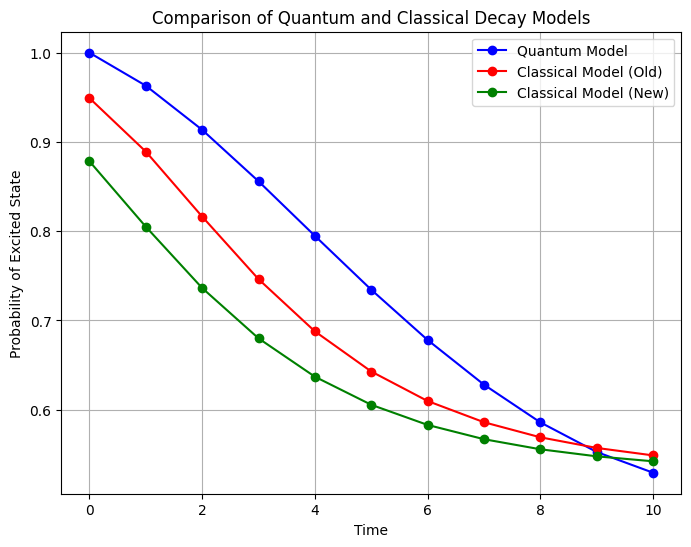

In [59]:
import numpy as np
import matplotlib.pyplot as plt

def plot_decay(time_points, quantum_decay, prOld, prNew):
    plt.figure(figsize=(8, 6))
    plt.plot(time_points, quantum_decay, 'bo-', label="Quantum Model")
    plt.plot(time_points, prOld, 'ro-', label="Classical Model (Old)")
    plt.plot(time_points, prNew, 'go-', label="Classical Model (New)")
    plt.xlabel("Time")
    plt.ylabel("Probability of Excited State")
    plt.title("Comparison of Quantum and Classical Decay Models")
    plt.legend()
    plt.grid(True)
    plt.show()

# Sample time points
time_points = np.arange(11)

# Assuming the fitted parameters from optimization
params_quantum = [0.1, 2.0, 0.033, 0.9]  # Example fitted parameters for the quantum model
params_4param = [0.8, 2.0, 1.0, 0.8, 1.0, 1.0]  # Example fitted parameters for the classical model

# Compute the decay curves
quantum_decay = quantum_model(params_quantum, time_points, 3)  # Using actual function from notebook
G, pr = fitr2(result_4param.x, Pold, Pnew, nd, 1)
prOld, prNew = pr[:, 0], pr[:, 1]  # Ensure proper shape

# Generate the plot
plot_decay(time_points, quantum_decay, prOld, prNew)


In [ ]:
# Compute BIC for each model
bic_4param = compute_bic(G_4param, 4, num_obs)  # 4 parameters for the 4-parameter model
bic_quantum = compute_bic(G_quantum, num_free_params, num_obs)

# Compute the BIC difference
bic_diff = bic_quantum - bic_4param

# Display the BIC comparison
print(f"BIC (4-parameter model): {bic_4param}")
print(f"BIC (Quantum model): {bic_quantum}")
print(f"BIC Difference (Quantum - 4-param): {bic_diff}")

# Interpretation
if bic_diff > 10:
    print("Strong evidence for the 4-parameter model.")
elif 6 < bic_diff <= 10:
    print("Moderate evidence for the 4-parameter model.")
elif 2 < bic_diff <= 6:
    print("Weak evidence for the 4-parameter model.")
else:
    print("Minimal evidence; both models are comparable.")